## Import the necessary libraries

In [ ]:
!wget https://drive.google.com/uc?export=download&id=173tvWt-qPyAqZJc1KoBiUHgoSg6nLUtT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA

2022-12-11 14:08:04.982698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 14:08:05.286262: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /app/lib
2022-12-11 14:08:05.286295: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-11 14:08:06.670305: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No s

## Investigate the dataset

In [2]:
random_seed = 69
np.random.seed(random_seed)

df = pd.read_csv('munster_hourly.csv', parse_dates=["DATUM"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATUM        35672 non-null  datetime64[ns]
 1   STATIONS_ID  35672 non-null  int64         
 2   QN_4         35672 non-null  int64         
 3   TT_TER       35672 non-null  float64       
 4   RF_TER       35672 non-null  float64       
 5   VGSL         35672 non-null  float64       
 6   TS05         35672 non-null  float64       
 7   BF10         35672 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 2.2 MB


In [3]:
df

,DATUM,STATIONS_ID,QN_4,TT_TER,RF_TER,VGSL,TS05,BF10
0,1991-01-01 07:00:00,1766,10,3.0,91.0,0.3,2.9,102
1,1991-01-01 14:00:00,1766,10,4.8,85.0,0.3,2.9,102
2,1991-01-01 21:00:00,1766,10,3.9,82.0,0.3,2.9,102
3,1991-01-02 07:00:00,1766,10,5.6,94.0,1.4,6.3,110
4,1991-01-02 14:00:00,1766,10,11.0,87.0,1.4,6.3,110
...,...,...,...,...,...,...,...,...
35667,2021-12-30 00:00:00,1766,1,11.6,90.0,0.8,9.4,104
35668,2021-12-30 06:00:00,1766,1,11.1,98.0,0.8,9.4,104
35669,2021-12-30 12:00:00,1766,1,14.3,83.0,0.8,9.4,104
35670,2021-12-30 18:00:00,1766,1,13.5,90.0,0.8,9.4,104


/tmp/ipykernel_5739/2793083954.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)


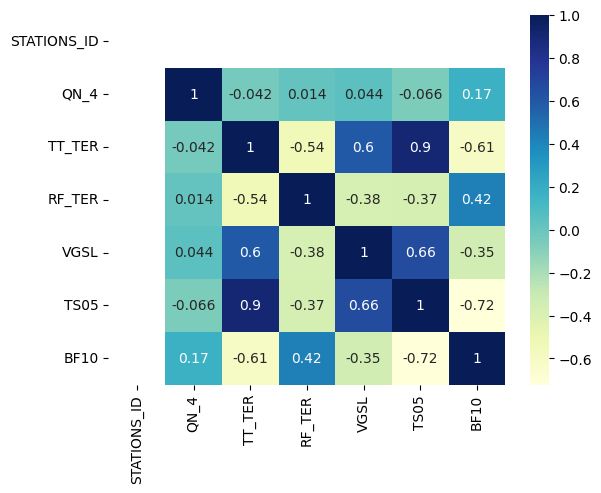

In [4]:
# DF Correletion
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [8]:
print(df.STATIONS_ID.unique())
print(df.QN_4.unique())

[1766]
[10  3  1]


In [5]:
df2 = df.copy()
df2 = df2[["DATUM", "BF10"]]
df2.DATUM = df2.DATUM.astype('datetime64[ns]')
df2 = df2.groupby(pd.Grouper(key='DATUM', axis=0, freq='D', sort=True)).mean()
df2['BF10'] = df2["BF10"].astype('int32')
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1991-01-01 to 2021-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   BF10    11323 non-null  int32
dtypes: int32(1)
memory usage: 132.7 KB


In [10]:
df2

,BF10
DATUM,
1991-01-01,102
1991-01-02,110
1991-01-03,110
1991-01-04,106
1991-01-05,109
...,...
2021-12-27,97
2021-12-28,104
2021-12-29,107


In [9]:
df2.describe()

,BF10
count,11323.000000
mean,71.004063
std,37.056605
min,0.000000
25%,41.000000
50%,88.000000
75%,102.000000
max,111.000000


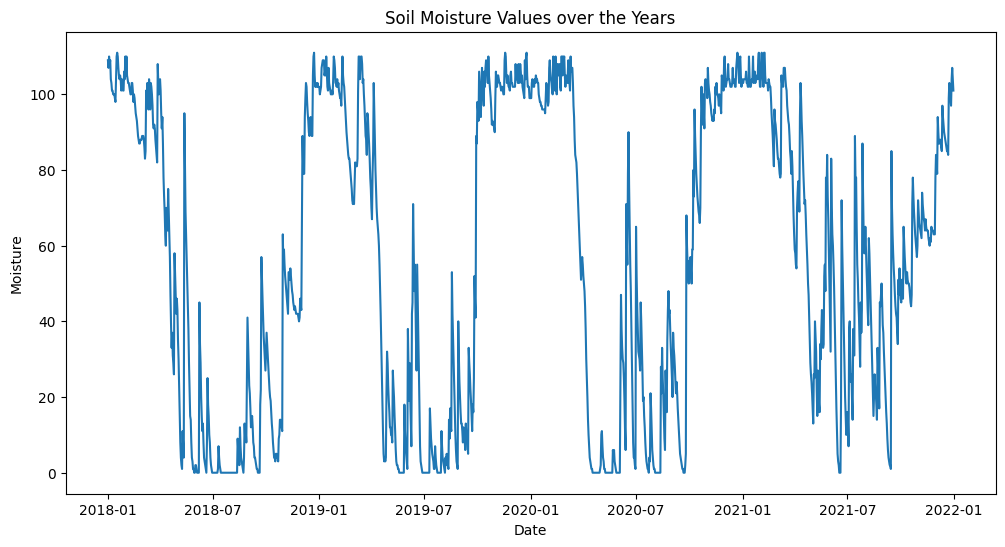

In [11]:
plt.figure(figsize=(12,6))
plt.title('Soil Moisture Values over the Years')
plt.xlabel('Date')
plt.ylabel('Moisture')
plt.plot(df2['BF10']['2018':])

In [12]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
   
ADF_test(df2)

Results of Dickey-Fuller Test:
Test Statistic                -9.321864e+00
p-value                        9.843300e-16
Lags Used                      1.600000e+01
Number of Observations Used    1.130600e+04
Critical Value (1%)           -3.430929e+00
Critical Value (5%)           -2.861796e+00
Critical Value (10%)          -2.566906e+00
dtype: float64


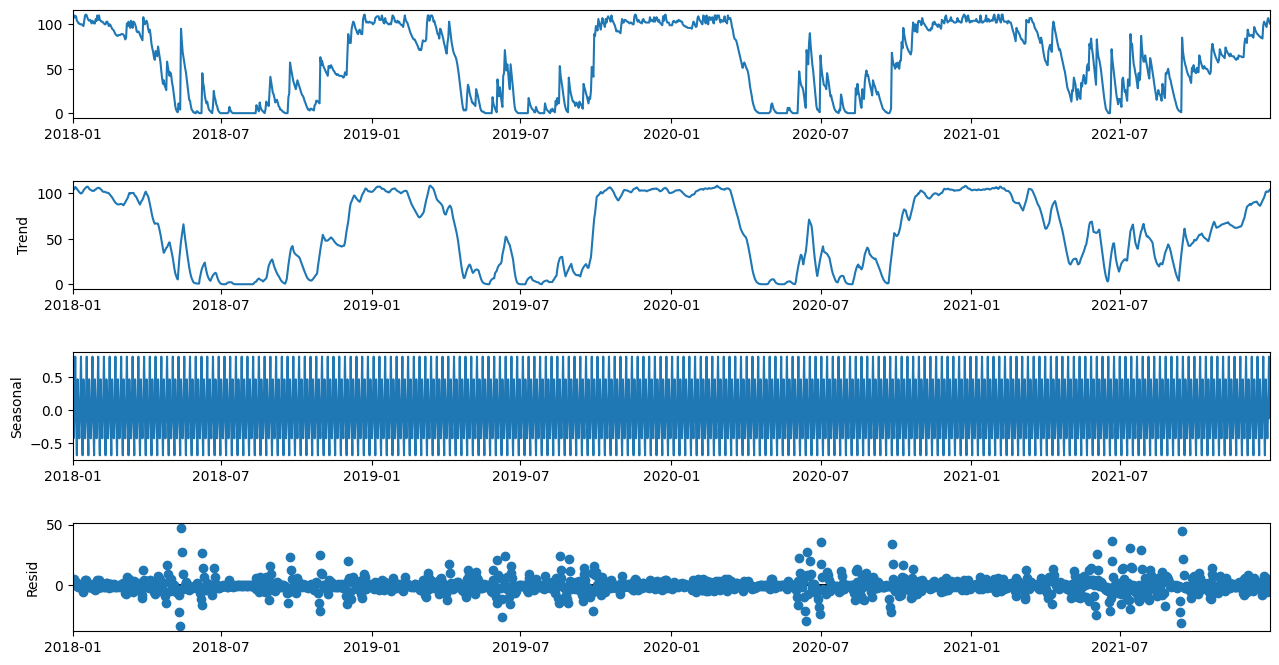

In [13]:
analysis = seasonal_decompose(df2['2018':], model='additive', extrapolate_trend=12)
    
fig = analysis.plot()
fig.set_size_inches(14, 7)
plt.show()

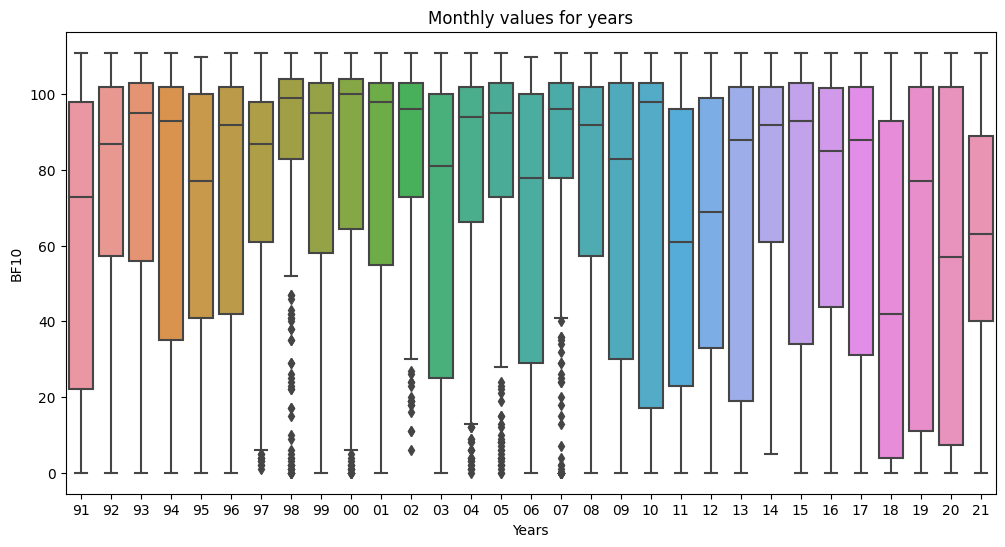

In [14]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(x=df2.index.strftime("%y"), y=df2["BF10"])
plt.title("Monthly values for years")
plt.xlabel("Years")
plt.show()

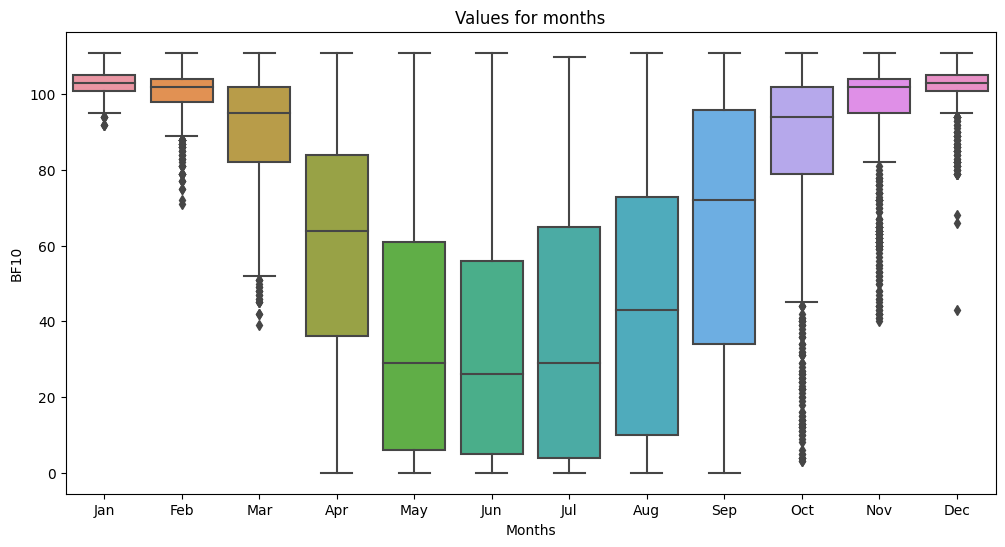

In [15]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x=df2.index.strftime("%b"), y=df2["BF10"], ax=ax)
plt.title("Values for months")
plt.xlabel("Months")
plt.show()

In [ ]:
train_data, test_data = train_test_split(df2, shuffle=False, test_size=0.2, random_state=42)

In [ ]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 10))
ax1.plot(train_data.BF10)
ax1.set_title('Original Series')
ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(train_data.BF10.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(train_data.BF10.diff().diff())
ax3.set_title('2nd Order Differencing')
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 12))
_ = plot_acf(train_data.BF10, ax=ax1)
_ = plot_acf(train_data.BF10.diff().dropna(), ax=ax2)
ax2.set_title('Autocorrelation for first-order differencing')
_ = plot_acf(train_data.BF10.diff().diff().dropna(), ax=ax3)
ax3.set_title('Autocorrelation for second-order differencing')

In [ ]:
fig = plot_pacf(df["BF10"], lags=30).set_size_inches(10,5)
plt.title('Partial Autocorrelation of BF10',)
plt.xlabel("Lags")
plt.ylabel("Correlation coefficient")
plt.show()

In [ ]:
import pmdarima as pm

ARIMA_model = pm.auto_arima(train_data, m=12)
ARIMA_model.summary()

In [ ]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(df2['BF10'][-24:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base df2
df2['month'] = df2.index.month
df2 = pd.merge(df2, seasonal_index, how='left', on='month')
df2.columns = ['BF10', 'month', 'seasonal_index']
df2.index = df2.index  # reassign the index.

In [ ]:
# SARIMAX Model
sxmodel = pm.auto_arima(df[['BF10']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

In [ ]:
# Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.value, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()

In [ ]:
FORECAST = 2
df2['Prediction'] = df2[['BF10']].shift(-FORECAST)

In [ ]:
# Create X and y variables shifted by the number of days we want to predict.
X = df2[['BF10']][:-FORECAST]
y = df2[['Prediction']][:-FORECAST]

sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)
y = sc.fit_transform(y)

# Divide the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=42)

print("", X_train.shape, "\n", y_train.shape,
      "\n", X_test.shape, "\n", y_test.shape)

In [ ]:
forest = RandomForestRegressor().fit(X_train, y_train)
linear = LinearRegression().fit(X_train, y_train)

In [ ]:
y_test

In [ ]:
forest_pred = forest.predict(X_test)
lr_pred = linear.predict(X_test)

forest_pred = sc.inverse_transform(forest_pred.reshape(-1, 1))
lr_pred = sc.inverse_transform(lr_pred.reshape(-1, 1))

prediction = pd.DataFrame(lr_pred, index=df2[9056+FORECAST:].index, columns = ['lr_BF10'])
prediction['fr_BF10'] = forest_pred
prediction['Actuals'] = sc.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12,6))
plt.plot(prediction['Actuals']['2020'], label = 'ACtual')
plt.plot(prediction['lr_BF10']['2020'], label = 'lr_BF10')
plt.plot(prediction['fr_BF10']['2020'], label = 'fr_BF10')
plt.legend()
plt.title('Moisture level comparisons')  
plt.ylabel("Moisture")
plt.xlabel('Date')
plt.show()

In [ ]:
print('LINEAR REGRESSION: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, lr_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, lr_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, lr_pred)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, lr_pred), 4))
print(f'Train Score: {linear.score(X_train, y_train) * 100:.2f}% and Test Score: {linear.score(X_test, y_test) * 100:.2f}% using Linear Regression.')
print('')
print('RANDOM FOREST REGRESSOR: \n-------------------------------------------')
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, forest_pred), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, forest_pred), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, forest_pred)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, forest_pred), 4))
print(f'Train Score: {forest.score(X_train, y_train) * 100:.2f}% and Test Score: {forest.score(X_test, y_test) * 100:.2f}% using Random Forest Regressor.')